In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from cre_reg.optimization import optimize_weights
from cre_reg.negative_log_likelihood import eval_naive_log_Pij, evaluate_nll
from cre_reg.regularization import entropy_regularization, anchor_regularization, tikhonov_regularization
from cre_reg.experiments.two_gaussian_mixture import TwoGaussianModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Generate the Data

In [2]:
# Parameters for the dataset
n_images = 100000
num_structures = 41
noise_stdev = 0.6
num_epochs = 100

In [3]:
# Generate the images
tgm = TwoGaussianModel()
noiseless_images = tgm.sample(n_images).to(device)
images = noiseless_images + noise_stdev * torch.randn_like(noiseless_images)


Plot the data to see the effect of the noise.

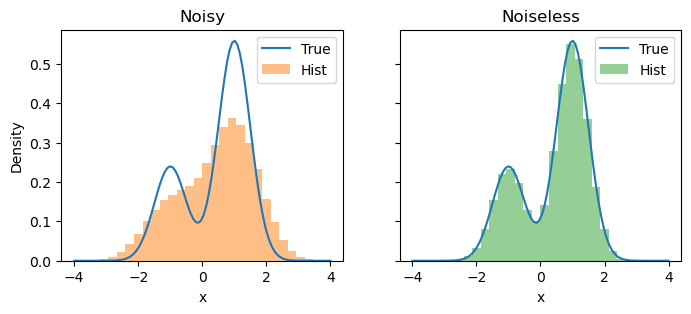

In [4]:

# Functional form of the Boltzmann Density for Reference.
xax = torch.linspace(-4, 4, 100)
pi = tgm.evaluate_boltzmann(xax)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
nbins = 30
for ax in axes:
    ax.plot(xax, pi, label='True', c='C0')

axes[0].hist(images.cpu().numpy(), bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')
axes[1].hist(noiseless_images.cpu().numpy(), bins=nbins, range=(-4, 4), 
             color="C2", density=True, alpha=0.5, label='Hist')

for ax in axes:
    ax.set_xlabel('x')
    ax.legend()
axes[0].set_title('Noisy')
axes[1].set_title('Noiseless')
axes[0].set_ylabel('Density')
plt.show()


# Perform the Reweighting

Construct the structures and evaluate the log-likelihood pairs.

In [5]:
# Evently spaced clusters:
x = torch.linspace(-4, 4, num_structures, device=device)
negative_log_weights = torch.randn_like(x) * 0.01 # Random initial weights
cluster_sizes = torch.ones_like(negative_log_weights)

distance_matrix = (images.unsqueeze(1) - x.unsqueeze(0))**2
log_Pij = eval_naive_log_Pij(distance_matrix, noise_stdev)
print(log_Pij.shape)

torch.Size([100000, 41])


In [6]:
reg_strengths = np.logspace(-4, 4, 21)
print(reg_strengths)


[1.00000000e-04 2.51188643e-04 6.30957344e-04 1.58489319e-03
 3.98107171e-03 1.00000000e-02 2.51188643e-02 6.30957344e-02
 1.58489319e-01 3.98107171e-01 1.00000000e+00 2.51188643e+00
 6.30957344e+00 1.58489319e+01 3.98107171e+01 1.00000000e+02
 2.51188643e+02 6.30957344e+02 1.58489319e+03 3.98107171e+03
 1.00000000e+04]


In [7]:

optimized_values = []

for reg_strength in tqdm(reg_strengths):
    def new_regularization_fxn(negative_log_weights):
        reg_loss = reg_strength * entropy_regularization(negative_log_weights)
        return reg_loss
    
    loss_fxn = lambda negative_log_weights: evaluate_nll(negative_log_weights, log_Pij)

    optimized_negative_log_weight_entropy_reg, losses_reg = optimize_weights(
        log_Pij, loss_fxn, cluster_sizes=cluster_sizes, regularization_fxn=new_regularization_fxn,
        num_epochs=num_epochs,
        )

    optimized_boltzmann_w_reg = torch.exp(-optimized_negative_log_weight_entropy_reg)
    optimized_boltzmann_w_reg /= optimized_boltzmann_w_reg.sum() * (x[1] - x[0])
    optimized_values.append(optimized_boltzmann_w_reg.detach().cpu().numpy())

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


In [8]:
log_likelihoods_per_reg = [loss_fxn(torch.from_numpy(v).cuda()).item() for v in optimized_values]

dydx = np.gradient(log_likelihoods_per_reg, np.log(reg_strengths))
d2ydx2 = np.gradient(dydx, np.log(reg_strengths))


In [9]:
biggest_curvature = np.argmax(d2ydx2)
smallest_curvature = np.argmin(d2ydx2)
in_between = (biggest_curvature + smallest_curvature) // 2
# print(biggest_curvature)
# plt.semilogx(reg_strengths, d2ydx2)

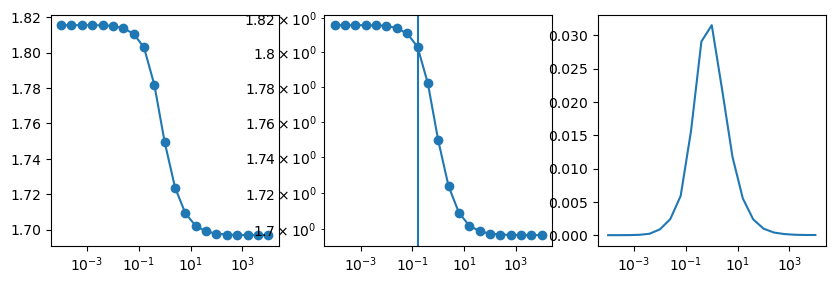

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True)

axes[0].semilogx(reg_strengths, log_likelihoods_per_reg, 'o-')  
axes[1].loglog(reg_strengths, log_likelihoods_per_reg, 'o-')
grad_log = np.gradient(log_likelihoods_per_reg, np.log(reg_strengths))
axes[2].semilogx(reg_strengths, -grad_log)
axes[1].axvline(reg_strengths[smallest_curvature])
# axes[1].set_title('Log-Log')

max_log_deriv = np.argmax(-grad_log)
max_deriv = np.argmax(-np.gradient(log_likelihoods_per_reg, reg_strengths))

In [11]:
print("Biggest curvature value", biggest_curvature)
print("most Negative curvature value", smallest_curvature)
print("In between value", in_between)
print("Max log deriv value", max_log_deriv)
print("max deriv value", max_deriv)
print(reg_strengths[smallest_curvature-6])
print(np.argmax(log_likelihoods_per_reg))

Biggest curvature value 11
most Negative curvature value 8
In between value 9
Max log deriv value 10
max deriv value 6
0.000630957344480193
1


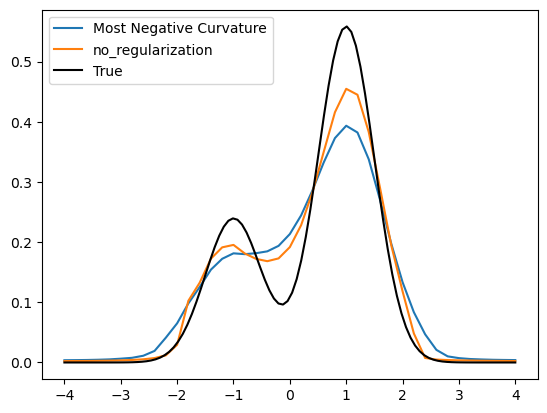

In [12]:
# cluster_sizes=cluster_sizes
# plt.plot(x.cpu(), optimized_values[biggest_curvature], label="biggest_curvature")
plt.plot(x.cpu(), optimized_values[smallest_curvature], label="Most Negative Curvature")
plt.plot(x.cpu(), optimized_values[7], label="no_regularization")
# plt.plot(x.cpu(), optimized_values[max_deriv], label="max_deriv")

plt.plot(xax, pi, label="True", color='k')
plt.legend()